
# Ilusión de Mayoría en Redes *Scale-Free*

**Objetivo general.** Reproducir la Fig. 2 del paper *“The Majority Illusion in Social Networks”* usando redes *scale-free*, cumpliendo **estrictamente** los valores de asortatividad por grado $r_{kk}$ por panel y mostrando la probabilidad de mayoría $P_{>1/2}$ como función de la correlación grado–atributo $\rho_{kx}$.

**Escenario del experimento (igual al paper):**  
- Cada red tiene $N=10{,}000$ nodos con distribución de grados $p(k)\sim k^{-\alpha}$.  
- La fracción de nodos activos es $p=0.05$ (5%).  
- Se barre $\rho_{kx}$ y se repite para varios $r_{kk}$ objetivo.  
- Se grafica $P_{>1/2}$ vs $\rho_{kx}$ (eje X usa la **$\rho$ medida**).





## Pseudocódigo

```
para cada α en {2.1, 2.4, 3.1}:
    para cada rObjetivo en rPorPanel[α]:
        # 1) Construcción de la red
        grados <- MuestrearGradosPotencia(N, α, kMin, kMax)
        G <- GrafoSimpleDesdeSecuencia(grados)

        # 2) Ajuste estricto de r_kk
        rMedido <- RewirearRkkEstrictamente(G, rObjetivo, tolerancia=0.003):
            - calcular A,B,C,M (constantes salvo A) con la secuencia de grados
            - mientras |r(G) - rObjetivo| > tolerancia y queden pasos:
                * elegir dos aristas con sesgo por extremos (alto/alto vs bajo/bajo)
                * evaluar ΔA para swaps candidatos y aplicar el que más acerque a rObjetivo
                * actualizar A y r en O(1)
            - pulido adicional y reintentos con semillas nuevas si no se alcanza

        # 3) Barrido en ρ_kx (prevalencia fija p=0.05)
        para cada ρObjetivo en grillaRho:
            x <- AsignarAtributoConRhoYP(k, ρObjetivo, p, por bisección en β usando exp(β log k))
            Pmay <- ProbabilidadMayoria(G, x, dominio="gcc")
            guardar (ρMedida, Pmay)

graficar tres paneles con curvas por r_kk y eje X = ρMedida
```


In [1]:

import numpy as np
import networkx as nx
import scipy.sparse as sp
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional



## Configuración del experimento


In [2]:

@dataclass
class Config:
    # Núcleo
    N: int = 100
    alphas: Tuple[float, ...] = (2.1, 2.4, 3.1)
    rPorAlpha: Dict[float, Tuple[float, ...]] = None
    rhoGrid: Tuple[float, ...] = tuple(np.round(np.linspace(0.0, 0.55, 50), 2))
    pGlobal: float = 0.05  # 5%

    # Secuencia de grados
    kMin: int = 1 #2
    kMax: Optional[int] = None   # se fija más abajo con corte estructural

    # Rewire estricto
    tolREstricto: float = 0.003
    pasosPorAristaPrimera: float = 8.0
    pasosPorAristaPulido: float = 8.0
    reintentos: int = 4
    semillaBase: int = 123

    # Asignación de atributo (ρ_kx)
    tolRho: float = 0.015
    maxBiseccionBeta: int = 24

    # Medición
    sampleNodes: Optional[int] = None   # ej. 4000 para acelerar
    dominio: str = "gcc"                # "gcc" (paper) o "all"

CFG = Config()
CFG.rPorAlpha = {
    2.1: (-0.35, -0.25, -0.15, -0.05),
    2.4: (-0.20, -0.10,  0.00,  0.10,  0.20),
    3.1: (-0.15, -0.05,  0.00,  0.30),
}
# Corte estructural: kMax ≈ sqrt(N * <k>) con <k> ≈ 8
CFG.kMax = int(2*(CFG.N * 8)**0.5)
#CFG



## Construcción de redes *scale-free* (secuencia y grafo simple)


In [3]:

def muestrearGradosPotencia(N: int, alpha: float, kMin: int, kMax: int, rng):
    ks = np.arange(kMin, kMax + 1, dtype=int)
    pk = ks.astype(float) ** (-alpha)
    pk = pk / pk.sum()
    deg = rng.choice(ks, size=N, replace=True, p=pk)
    if deg.sum() % 2 == 1:
        i = rng.integers(0, N)
        deg[i] = min(deg[i] + 1, kMax)
    return deg

def grafoSimpleDesdeSecuencia(deg: np.ndarray, seed: int = 42) -> nx.Graph:
    Gm = nx.configuration_model(deg, seed=seed)
    G = nx.Graph(Gm)
    G.remove_edges_from(nx.selfloop_edges(G))
    return G



## Rewire de $r_{kk}$ — estrategia guiada, pulido y reintentos


In [4]:

def constantesAsortatividadDesdeGrados(G: nx.Graph, deg: Dict[int,int] = None):
    if deg is None:
        deg = dict(G.degree())
    M = G.number_of_edges()
    dvals = np.array(list(deg.values()), dtype=float)
    B = 0.5 * np.sum(dvals**2)
    C = 0.5 * np.sum(dvals**3)
    A = 0
    for u, v in G.edges():
        A += deg[u]*deg[v]
    denom = (C/M) - (B/M)**2
    return A, B, C, M, denom, deg

def asortatividadDesdeA(A: float, B: float, C: float, M: float) -> float:
    return (A/M - (B/M)**2) / (C/M - (B/M)**2)

def elegirAristasPorExtremos(edges, deg, rng, direccion):
    d = np.array([deg[u]+deg[v] for (u,v) in edges])
    q_hi = np.quantile(d, 0.8); q_lo = np.quantile(d, 0.2)
    hi_idx = np.where(d >= q_hi)[0]; lo_idx = np.where(d <= q_lo)[0]
    if direccion < 0:
        i = rng.choice(hi_idx) if hi_idx.size else rng.integers(len(edges))
        j = rng.choice(lo_idx) if lo_idx.size else rng.integers(len(edges))
    else:
        i = rng.integers(len(edges)); j = rng.integers(len(edges))
    return int(i), int(j)

def pasadaRewire(G: nx.Graph, rObjetivo: float, pasosPorArista: float, tol: float, seed: int) -> float:
    rng = np.random.default_rng(seed)
    A, B, C, M, denom, deg = constantesAsortatividadDesdeGrados(G)
    if denom <= 0:
        return nx.degree_assortativity_coefficient(G)
    r = asortatividadDesdeA(A, B, C, M)
    edges: list = list(G.edges())
    adj = {u: set(G.neighbors(u)) for u in G.nodes()}
    steps = int(pasosPorArista * M)
    direccion = 1 if rObjetivo > r else -1

    for _ in range(steps):
        i, j = elegirAristasPorExtremos(edges, deg, rng, direccion)
        if i == j: 
            continue
        a, b = edges[i]; c, d = edges[j]
        if len({a,b,c,d}) < 4:
            continue
        v1 = (c not in adj[a]) and (d not in adj[b]) and (a!=c) and (b!=d)
        v2 = (d not in adj[a]) and (c not in adj[b]) and (a!=d) and (b!=c)
        if not (v1 or v2):
            continue

        ka,kb,kc,kd = deg[a],deg[b],deg[c],deg[d]
        actual = ka*kb + kc*kd
        delta1 = (ka*kc + kb*kd) - actual
        delta2 = (ka*kd + kb*kc) - actual

        cand = []
        if v1: cand.append(("ac_bd", delta1))
        if v2: cand.append(("ad_bc", delta2))
        if not cand: 
            continue

        etiqueta, delta = max(cand, key=lambda x:x[1]) if direccion>0 else min(cand, key=lambda x:x[1])
        if (direccion>0 and delta<=0) or (direccion<0 and delta>=0):
            continue

        G.remove_edge(a,b); adj[a].remove(b); adj[b].remove(a)
        G.remove_edge(c,d); adj[c].remove(d); adj[d].remove(c)
        if etiqueta=="ac_bd":
            G.add_edge(a,c); adj[a].add(c); adj[c].add(a)
            G.add_edge(b,d); adj[b].add(d); adj[d].add(b)
            edges[i]=(a,c); edges[j]=(b,d)
        else:
            G.add_edge(a,d); adj[a].add(d); adj[d].add(a)
            G.add_edge(b,c); adj[b].add(c); adj[c].add(b)
            edges[i]=(a,d); edges[j]=(b,c)

        A += delta
        r = asortatividadDesdeA(A,B,C,M)
        direccion = 1 if rObjetivo > r else -1
        if abs(r - rObjetivo) <= tol:
            break
    return r

def rewirearRkkEstrictamente(G: nx.Graph, rObjetivo: float, cfg: 'Config') -> float:
    for intento in range(cfg.reintentos):
        semilla = cfg.semillaBase + 97*intento
        r1 = pasadaRewire(G, rObjetivo, cfg.pasosPorAristaPrimera, cfg.tolREstricto, semilla)
        if abs(r1 - rObjetivo) <= cfg.tolREstricto:
            return r1
        r2 = pasadaRewire(G, rObjetivo, cfg.pasosPorAristaPulido, cfg.tolREstricto, semilla+1)
        if abs(r2 - rObjetivo) <= cfg.tolREstricto:
            return r2
        try:
            G = nx.double_edge_swap(G, nswap=int(0.5*G.number_of_edges()), max_tries=G.number_of_edges()*5)
        except Exception:
            pass
    return nx.degree_assortativity_coefficient(G)



## Asignación robusta del atributo con $\rho_{kx}$ objetivo


In [5]:

def pearsonKBinario(k, x):
    k = np.asarray(k, dtype=float)
    x = np.asarray(x, dtype=float)
    kc = k - k.mean()
    xc = x - x.mean()
    denom = np.sqrt(np.sum(kc**2) * np.sum(xc**2))
    if denom == 0:
        return 0.0
    return float(np.dot(kc, xc) / denom)

def asignarAtributoConRhoYP(k: np.ndarray, rhoObjetivo: float, p: float,
                            tol: float, maxIter: int, rng):
    N = len(k); m = int(round(p * N))
    m = max(1, min(N-1, m))

    k = np.asarray(k, dtype=float)
    if np.any(k <= 0):
        pos = k[k > 0]
        kmin_pos = float(pos.min()) if pos.size > 0 else 1.0
        k_eff = k.copy(); k_eff[k_eff <= 0] = kmin_pos
    else:
        k_eff = k

    logk = np.log(k_eff)
    lo, hi = -12.0, +12.0
    x_best, rho_best = None, -1.0

    for _ in range(maxIter):
        beta = 0.5*(lo+hi)
        w = np.exp(beta * logk)
        w[~np.isfinite(w)] = 0.0
        s = w.sum()
        if not np.isfinite(s) or s <= 0.0:
            w = np.ones_like(w) / N
        else:
            w = w / s

        idx = rng.choice(N, size=m, replace=False, p=w)
        x = np.zeros(N, dtype=np.int8); x[idx] = 1

        rho = pearsonKBinario(k, x)
        x_best, rho_best = x, rho
        if abs(rho - rhoObjetivo) <= tol:
            break
        if rho < rhoObjetivo: lo = beta
        else: hi = beta

    return x_best, rho_best



## Medición de $P_{>1/2}$ (GCC por defecto)


In [6]:

def probabilidadMayoria(G: nx.Graph, x: np.ndarray, sampleNodes: Optional[int], dominio: str, rng):
    if dominio not in {"gcc", "all"}:
        raise ValueError("dominio debe ser 'gcc' o 'all'")
    if dominio == "gcc":
        GCC = max(nx.connected_components(G), key=len)
        H = G.subgraph(GCC).copy()
        nodos = np.array(list(H.nodes()), dtype=int)
        xH = x[nodos]
        A = nx.to_scipy_sparse_array(H, format="csr", dtype=np.int8)
        deg = np.asarray(A.sum(1)).ravel()
        ok = deg > 0
        if sampleNodes is not None and sampleNodes < ok.sum():
            idx = np.where(ok)[0]
            choose = rng.choice(idx, size=sampleNodes, replace=False)
            mask = np.zeros_like(ok, dtype=bool); mask[choose] = True
            ok = mask
        counts = (A @ xH)
        return (counts[ok] > 0.5*deg[ok]).mean()
    else:
        A = nx.to_scipy_sparse_array(G, format="csr", dtype=np.int8)
        deg = np.asarray(A.sum(1)).ravel()
        ok = deg > 0
        if sampleNodes is not None and sampleNodes < ok.sum():
            idx = np.where(ok)[0]
            choose = rng.choice(idx, size=sampleNodes, replace=False)
            mask = np.zeros_like(ok, dtype=bool); mask[choose] = True
            ok = mask
        counts = (A @ x)
        return (counts[ok] > 0.5*deg[ok]).mean()



## Pipeline por panel (α fijo) con $r_{kk}$


In [7]:

def ejecutarConfiguracion(alpha: float, rObjetivos: Tuple[float, ...], cfg: 'Config'):
    resultados = {}
    rMedidos = {}
    rng = np.random.default_rng(cfg.semillaBase)

    for idx, rObj in enumerate(rObjetivos):
        grados = muestrearGradosPotencia(cfg.N, alpha, cfg.kMin, cfg.kMax, rng)
        G = grafoSimpleDesdeSecuencia(grados, seed=cfg.semillaBase + 31*idx)
        rFinal = rewirearRkkEstrictamente(G, rObj, cfg)
        rMedidos[rObj] = rFinal
        if abs(rFinal - rObj) > cfg.tolREstricto:
            print(f"[ADVERTENCIA] α={alpha}, rObjetivo={rObj:+.2f}, rMedido={rFinal:+.4f}")
        k = np.array([d for _, d in sorted(G.degree(), key=lambda x: x[0])], dtype=int)
        rhos, pvals = [], []
        for rhoObj in cfg.rhoGrid:
            x, rhoReal = asignarAtributoConRhoYP(k, rhoObj, cfg.pGlobal, cfg.tolRho, cfg.maxBiseccionBeta, rng)
            p = probabilidadMayoria(G, x, cfg.sampleNodes, cfg.dominio, rng)
            rhos.append(float(rhoReal)); pvals.append(float(p))
        orden = np.argsort(rhos)
        resultados[rObj] = (np.array(rhos)[orden], np.array(pvals)[orden])

    return resultados, rMedidos



## Visualización: tres paneles en una fila


In [8]:

def ejecutarConfiguraciones(cfg: 'Config'):
    resultadosAlpha, rMedidosAlpha = {}, {}
    for a in cfg.alphas:
        res, rMed = ejecutarConfiguracion(a, cfg.rPorAlpha[a], cfg)
        resultadosAlpha[a] = res
        rMedidosAlpha[a] = rMed
    return resultadosAlpha, rMedidosAlpha

def graficarResultados(resultadosAlpha, rMedidosAlpha, cfg: 'Config', usarEtiquetasObjetivo: bool = False):
    fig, axes = plt.subplots(1, 3, figsize=(13.5, 4), dpi=120, sharex=True, sharey=True)
    markerSets = {2.1:["o","^","s","x"], 2.4:["o","^","s","D","x"], 3.1:["o","^","s","x"]}
    titulos = {2.1:r"(a) $\alpha=2.1$", 2.4:r"(b) $\alpha=2.4$", 3.1:r"(c) $\alpha=3.1$"}
    for ax, a in zip(axes, cfg.alphas):
        markers = markerSets[a]
        for i, rObj in enumerate(cfg.rPorAlpha[a]):
            rhos, vals = resultadosAlpha[a][rObj]
            etiqueta = rf"$r_{{kk}}={rObj:+.2f}$" if usarEtiquetasObjetivo else rf"$r_{{kk}}={rMedidosAlpha[a][rObj]:+.2f}$"
            ax.plot(rhos, vals, marker=markers[i%len(markers)], linewidth=1.8, markersize=5.5, label=etiqueta)
        ax.set_title(titulos[a]); ax.grid(True, alpha=.25, linestyle="--")
        ax.set_xlim(min(cfg.rhoGrid)-0.02, max(cfg.rhoGrid)+0.02); ax.set_ylim(0,1.0)
        ax.set_xlabel(r"k–x correlation, $\rho_{kx}$")
        if a == cfg.alphas[0]:
            ax.set_ylabel(r"Probability of majority, $P_{>1/2}$")
        ax.legend(frameon=True, loc="upper left", fontsize=9)
    plt.tight_layout(); plt.show()



## Ejecutar (puedes activar muestreo para acelerar)


[ADVERTENCIA] α=2.4, rObjetivo=-0.20, rMedido=-0.1860
[ADVERTENCIA] α=2.4, rObjetivo=-0.10, rMedido=-0.1971
[ADVERTENCIA] α=2.4, rObjetivo=+0.20, rMedido=-0.0543
[ADVERTENCIA] α=3.1, rObjetivo=-0.15, rMedido=-0.2565


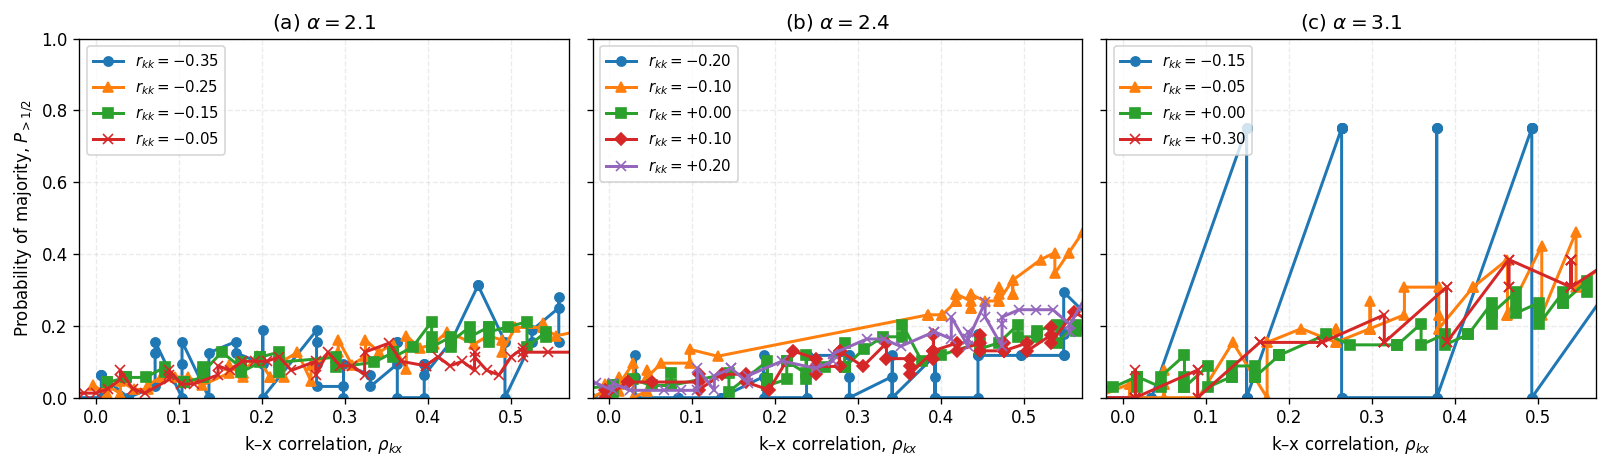

In [10]:

CFG.sampleNodes = 4000  # <- descomenta para acelerar
resultadosAlpha, rMedidosAlpha = ejecutarConfiguraciones(CFG)
graficarResultados(resultadosAlpha, rMedidosAlpha, CFG, usarEtiquetasObjetivo=True)
